In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import six
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.ops import math_ops
from deeplab import common
from deeplab import model
from deeplab.datasets import data_generator
from deeplab.utils import train_utils
import os
from deeplab.utils import get_dataset_colormap
from seg_exp import seg_encoder, seg_decoder
#from bls2017_comp_seg import build_model
import numpy as np
import sys
sys.path.append('/home/belbarashy/compression-1.1/')
import tensorflow_compression as tfc
import os
from logging_formatter import Logger
import pickle
import cv2
from deeplab.datasets import data_generator
from deeplab.utils import get_dataset_colormap
from seg_exp import softmax_cross_entropy_loss_mining, CBR, seg_encoder, seg_decoder, fuse_SSMA
from seg_exp import fuse_SSMA_like_sum, fuse_SSMA_like_concat



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
def build_model(x_rgb, x_depth, lmbda, num_classes, mode = 'training', seg_labels = None, ignore_label = None):
    # Args
    train_loss, bpp, mse, y_tilde_hat, x_tilde_hat, y, string, entropy_bottleneck, seg_logits = [None]*9
    seg_loss = None
    istraining = (mode == 'training')
    num_pixels = tf.to_float(tf.reduce_prod(tf.shape(x_rgb)[:-1]))

    y, skip = seg_encoder('Encoder', x_rgb, training=istraining)

    # ===================== Manipulate y (num_channels, 64, 128, 512)
    #s_1,s_2 = tf.image.image_gradients(x_rgb)
    #x_depth = s_1+s_2
    x_depth_downsampeld = tf.image.resize_bilinear(x_depth, tf.shape(y)[1:3], align_corners=True)
    x_depth_normalized  = x_depth_downsampeld / tf.reduce_max(x_depth_downsampeld)
    chs = []
    min_chs = 112#62
    for i in range(512):
        chs.append(y[:,:,:,i])
        if i < (512-min_chs):
            imp_mask_per_ch = tf.cast(tf.math.greater( tf.cast(i, tf.float32), 7*(x_depth_normalized*450)),  tf.float32)
            #imp_mask_per_ch = tf.cast(tf.math.greater( (x_depth_normalized*450) , 7*tf.cast(i, tf.float32) ),  tf.float32)
            chs[i] = chs[i] * imp_mask_per_ch[:,:,:,0]
        chs[i] = tf.expand_dims(chs[i], 3)
    y = tf.concat(chs, 3)        
    """
    for i in range(512):
        alpha = i/(2048)
        chs.append(y[:,:,:,i])
        imp_mask_per_ch = tf.cast(tf.math.greater(x_depth_downsampeld, alpha),  tf.float32)
        #imp_mask_per_ch = tf.expand_dims(imp_mask_per_ch, 3)
        if i < 482:
           chs[i] = chs[i] * imp_mask_per_ch[:,:,:,0]
        chs[i] = tf.expand_dims(chs[i], 3)
    y = tf.concat(chs, 3)
    """
    #shape = tf.shape(new_y)
    #imp_mask = tf.cast(tf.math.greater(x_depth_downsampeld, 0.2),  tf.float32)
    #y= y* imp_mask
    # =====================
    
    entropy_bottleneck = tfc.EntropyBottleneck()
    y_tilde_hat, likelihoods = entropy_bottleneck(y, training=istraining)
    skip = None
    # num_classes = -1 ==> reconstruct the rgb
    x_tilde_hat = seg_decoder('Decoder', y_tilde_hat, training=istraining, num_classes=-1, skip=skip)
    if mode == 'testing':
        string = entropy_bottleneck.compress(y)
        string = tf.squeeze(string, axis=0)

    # Loss
    bpp = tf.reduce_sum(tf.log(likelihoods)) / (-np.log(2) * num_pixels)
    mse = tf.reduce_mean(tf.squared_difference(x_rgb, x_tilde_hat))
    mse_map = tf.squared_difference(x_rgb, x_tilde_hat)
    
    if istraining:
        train_loss = lmbda * mse + bpp

    return train_loss, bpp, mse, x_tilde_hat, y_tilde_hat, y, string, entropy_bottleneck, seg_logits, seg_loss, mse_map


In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
tf.logging.set_verbosity(tf.logging.INFO)

dataset = data_generator.Dataset(
      dataset_name='cityscapes',
      split_name='val',
      dataset_dir='/datatmp/Experiments/belbarashy/datasets/Cityscapes/tfrecord/',
      batch_size=1,
      crop_size=[int(sz) for sz in [1024,2048]],
      min_resize_value=None,
      max_resize_value=None,
      resize_factor=None,
      model_variant=None,
      num_readers=2,
      is_training=False,
      should_shuffle=False,
      should_repeat=False)

samples = dataset.get_one_shot_iterator().get_next()
in_imgs = samples['image']/255
depth   = samples['depth'] /255
labels  = samples['label']  # channel=1


num_classes = dataset.num_of_classes

_, eval_bpp, mse, x_hat, y_hat, y, string, _, seg_logits, seg_loss, mse_map = \
build_model(in_imgs, depth, None, num_classes, mode='testing')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.dropout instead.


In [5]:
with tf.Session() as sess:
    #latest = tf.train.latest_checkpoint(checkpoint_dir='../experiments/exp_seg_wo_skip/')
    #latest = tf.train.latest_checkpoint(checkpoint_dir='../experiments/exp_seg_w_skip1by1_fixedlr/')
    latest = tf.train.latest_checkpoint(checkpoint_dir='/datatmp/Experiments/belbarashy/exps/seg_arch_for_compAndReconsrurction/lambda_8192.0/')
    print(latest)
    tf.train.Saver().restore(sess, save_path=latest)    
    for i in range(4): #17
        in_imgs_, y_, x_hat_, depth_ , bpp_, mse_, mse_map_ = sess.run([in_imgs, y, x_hat, depth , eval_bpp, mse, mse_map])
    
    #l = tf.reshape(l, shape=[-1])
    #l = tf.one_hot(l, num_classes, on_value=1.0, off_value=0.0)
    #print(one_hot_labels.shape)
in_imgs_ = np.squeeze(in_imgs_)
x_hat_= np.squeeze(x_hat_)
depth_ = np.squeeze(depth_)
mse_map_ = np.squeeze(mse_map_)
mse_map_ = cv2.cvtColor(mse_map_, cv2.COLOR_BGR2GRAY)
mse_map_ = mse_map_*(255**2)


/datatmp/Experiments/belbarashy/exps/seg_arch_for_compAndReconsrurction/lambda_8192.0/model.ckpt-200000
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /datatmp/Experiments/belbarashy/exps/seg_arch_for_compAndReconsrurction/lambda_8192.0/model.ckpt-200000


(1024, 2048, 3)
(1024, 2048, 3)
(1, 64, 128, 512)
(1024, 2048)
bpp:  0.38883635
mse:  156.7850378982257


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 2047.5, 1023.5, -0.5)

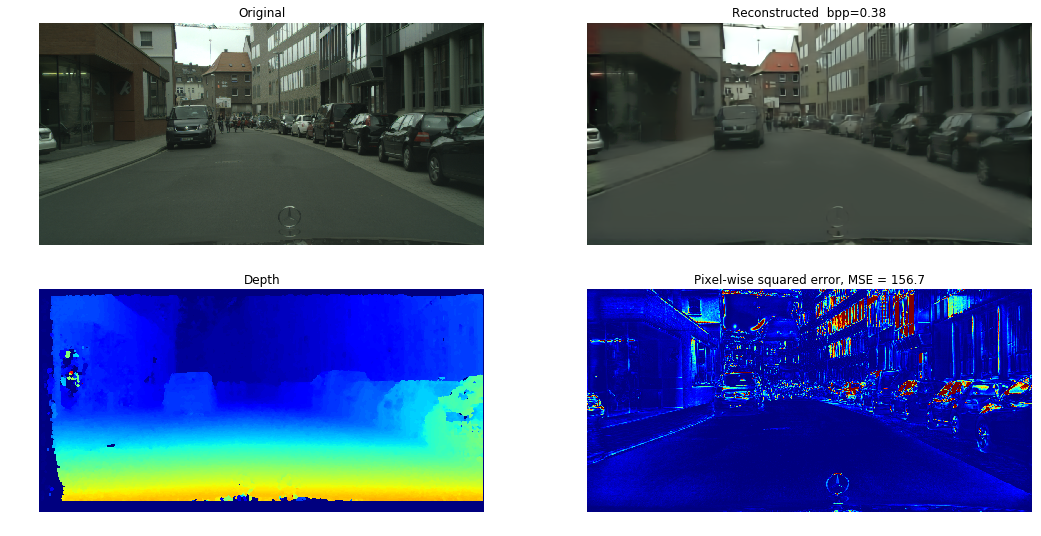

In [6]:
print(in_imgs_.shape)
print(x_hat_.shape)
print(y_.shape)
print(mse_map_.shape)
print('bpp: ', bpp_)
print('mse: ', mse_ * (255 ** 2))

plt.figure(figsize=(18, 9))
plt.subplot(221)
plt.imshow( in_imgs_ )
plt.title('Original')
plt.axis('off')


plt.subplot(222)#
plt.imshow( x_hat_)
plt.title('Reconstructed  bpp='+ str(bpp_)[:4] )
plt.axis('off')

plt.subplot(223)
plt.imshow( depth_, cmap='jet')
plt.title('Depth')

plt.axis('off')

plt.subplot(224)
plt.imshow(np.clip(mse_map_, 0, 1500),cmap='jet')
plt.title('Pixel-wise squared error, MSE = '+str(mse_ * (255 ** 2))[:5])
plt.axis('off')



In [7]:
print(depth_.min())
print(depth_.max())
print(depth_.mean())
print(depth_.std())

0.0
0.48627454
0.114924766
0.09839823
